Epoch 0: Loss = 0.084009, Estimated k = 1.0010
Epoch 500: Loss = 0.022593, Estimated k = 0.4851
Epoch 1000: Loss = 0.006753, Estimated k = 0.2884
Epoch 1500: Loss = 0.002765, Estimated k = 0.3471
Epoch 2000: Loss = 0.001560, Estimated k = 0.3866
Epoch 2500: Loss = 0.000887, Estimated k = 0.4133
Epoch 3000: Loss = 0.000605, Estimated k = 0.4351
Epoch 3500: Loss = 0.000578, Estimated k = 0.4516
Epoch 4000: Loss = 0.000240, Estimated k = 0.4632
Epoch 4500: Loss = 0.000198, Estimated k = 0.4715
Epoch 5000: Loss = 0.000206, Estimated k = 0.4774
Epoch 5500: Loss = 0.000091, Estimated k = 0.4818
Epoch 6000: Loss = 0.000117, Estimated k = 0.4852
Epoch 6500: Loss = 0.000067, Estimated k = 0.4875
Epoch 7000: Loss = 0.000064, Estimated k = 0.4894
Epoch 7500: Loss = 0.000080, Estimated k = 0.4909
Epoch 8000: Loss = 0.000075, Estimated k = 0.4919
Epoch 8500: Loss = 0.000092, Estimated k = 0.4929
Epoch 9000: Loss = 0.000030, Estimated k = 0.4934
Epoch 9500: Loss = 0.000260, Estimated k = 0.4941
Fina

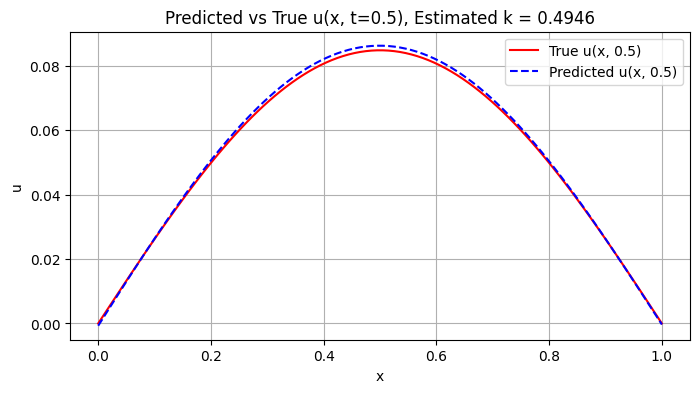

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Set seed for reproducibility
torch.manual_seed(0)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ True unknown constant to be discovered
k_true = 0.5

# ✅ Known solution to the PDE: u(x, t) = sin(pi * x) * exp(-pi^2 * k * t)
def true_u(x, t):
    return torch.sin(torch.pi * x) * torch.exp(-torch.pi**2 * k_true * t)

# ✅ Generate training points (x, t) and compute u(x,t)
N = 1000
x = torch.rand(N, 1).to(device)
t = torch.rand(N, 1).to(device)
u = true_u(x, t)  # ground truth

# ✅ Define a simple neural network for u(x, t)
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 80),
            nn.Tanh(),
            nn.Linear(80, 80),
            nn.Tanh(),
            nn.Linear(80, 1)
        )
        # Learnable unknown coefficient k
        self.k = nn.Parameter(torch.tensor([1.0], device=device))

    def forward(self, xt):
        return self.net(xt)

model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# ✅ Loss function = physics error + data error
def loss_fn(x, t, u_real):
    xt = torch.cat([x, t], dim=1).requires_grad_(True)  # combine x and t
    u_pred = model(xt)

    # Calculate du/dx and du/dt
    grad = torch.autograd.grad(u_pred, xt, torch.ones_like(u_pred), create_graph=True)[0]
    u_x = grad[:, 0:1]
    u_t = grad[:, 1:2]

    # Calculate second derivative: d²u/dx²
    grad2 = torch.autograd.grad(u_x, xt, torch.ones_like(u_x), create_graph=True)[0]
    u_xx = grad2[:, 0:1]

    # 🔵 Physics loss: check if PDE is satisfied
    physics_loss = torch.mean((u_t - model.k * u_xx) ** 2)

    # 🔵 Data loss: match the training data
    data_loss = torch.mean((u_pred - u_real) ** 2)


   # Stronger Dirichlet BC at x=0 and x=1 for multiple t values
    t_bc = torch.rand(100, 1).to(device)
    x0 = torch.zeros_like(t_bc).to(device)      # x = 0
    x1 = torch.ones_like(t_bc).to(device)       # x = 1

    xt0 = torch.cat([x0, t_bc], dim=1)
    xt1 = torch.cat([x1, t_bc], dim=1)

    u0 = model(xt0)
    u1 = model(xt1)

    bc_loss = torch.mean(u0**2) + torch.mean(u1**2)




    return physics_loss + data_loss + bc_loss


# ✅ Train the model
for epoch in range(10000):
    optimizer.zero_grad()
    loss = loss_fn(x, t, u)
    loss.backward()
    optimizer.step()

    # Show progress every 500 steps
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}, Estimated k = {model.k.item():.4f}")



# ✅ Continue training with LBFGS for fine-tuning
optimizer_lbfgs = torch.optim.LBFGS(model.parameters(), lr=1.0, max_iter=500)

def closure():
    optimizer_lbfgs.zero_grad()
    loss = loss_fn(x, t, u)
    loss.backward()
    return loss

optimizer_lbfgs.step(closure)

# ✅ Optional: print final estimate
print(f"Final estimate after LBFGS: k = {model.k.item():.4f}")


# 📈 Plot true vs predicted u(x, t)
x_plot = torch.linspace(0, 1, 100).unsqueeze(1).to(device)
t_plot = torch.full_like(x_plot, 0.5)  # fixed time t=0.5
xt_plot = torch.cat([x_plot, t_plot], dim=1)

with torch.no_grad():
    u_true_plot = true_u(x_plot, t_plot).cpu().numpy()
    u_pred_plot = model(xt_plot).cpu().numpy()

plt.figure(figsize=(8, 4))
plt.plot(x_plot.cpu(), u_true_plot, 'r-', label='True u(x, 0.5)')
plt.plot(x_plot.cpu(), u_pred_plot, 'b--', label='Predicted u(x, 0.5)')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.title(f'Predicted vs True u(x, t=0.5), Estimated k = {model.k.item():.4f}')
plt.grid(True)
plt.show()


##Obtainig "K" with the help of "Tensorflow" and "DeepXde"

In [2]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.3 MB/s eta 0:00:00


No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
✅ Backend in use: tensorflow.compat.v1
Compiling model...
Building feed-forward neural network...
'build' took 0.080160 s

'compile' took 0.591028 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.72e-01, 3.57e-02, 7.01e-01, 9.56e-02]    [1.72e-01, 3.57e-02, 7.01e-01, 9.56e-02]    []  
1000      [3.04e-03, 7.72e-04, 1.24e-03, 1.35e-03]    [3.04e-03, 7.72e-04, 1.24e-03, 1.35e-03]    []  
2000      [9.86e-04, 1.77e-04, 2.44e-04, 1.81e-04]    [9.86e-04, 1.77e-04, 2.44e-04, 1.81e-04]    []  
3000      [4.16e-04, 9.88e-05, 1.02e-04, 7.58e-05]    [4.16e-04, 9.88e-05, 1.02e-04, 7.58e-05]    []  
4000      [2.25e-04, 5.31e-05, 4.95e

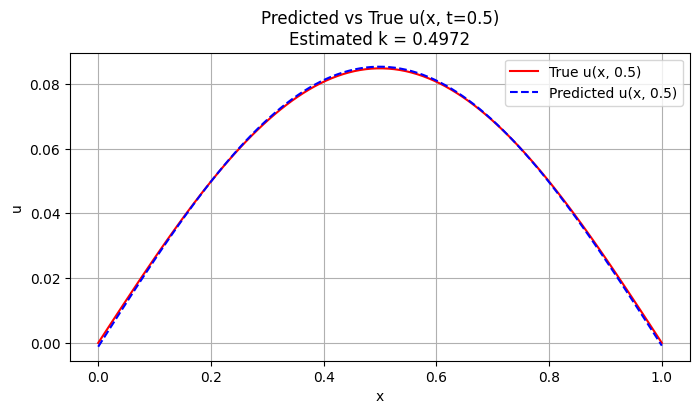

In [3]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# ✅ Backend info
print("✅ Backend in use:", dde.backend.backend_name)

# ✅ True parameter
k_true = 0.5

# ✅ Exact solution
def true_solution(x):
    x_val = x[:, 0:1]
    t_val = x[:, 1:2]
    return np.sin(np.pi * x_val) * np.exp(-np.pi**2 * k_true * t_val)

# ✅ PDE: u_t = k * u_xx
def pde(x, u):
    du_t = dde.grad.jacobian(u, x, i=0, j=1)
    du_xx = dde.grad.hessian(u, x, i=0, j=0)
    return du_t - k * du_xx

# ✅ Geometry and time domain
geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# ✅ Boundary and initial conditions
def boundary(x, on_boundary):
    return on_boundary

bc = dde.DirichletBC(geomtime, lambda x: 0, boundary)
ic = dde.IC(geomtime, lambda x: np.sin(np.pi * x[:, 0:1]), lambda x, on_initial: on_initial)

# ✅ Unknown variable
k = dde.Variable(1.0)

# ✅ Supervised data points (100 points from true solution)
N_data = 100
x_data = np.random.rand(N_data, 1)
t_data = np.random.rand(N_data, 1)
xt_data = np.hstack((x_data, t_data))
u_data = true_solution(xt_data)

observe_u = dde.PointSetBC(xt_data, u_data, component=0)

# ✅ Combine all data
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic, observe_u],
    num_domain=10000,
    num_boundary=200,
    num_initial=200,
)

# ✅ Network
net = dde.maps.FNN([2, 80, 80, 1], "tanh", "Glorot uniform")

# ✅ Model
model = dde.Model(data, net)

# ✅ Compile and train — make sure to include external_trainable_variables
model.compile("adam", lr=1e-3, external_trainable_variables=[k])
model.train(epochs=10000)

model.compile("L-BFGS-B", external_trainable_variables=[k])
model.train()

# ✅ Evaluate symbolic variable correctly in TF1
k_value = model.sess.run(k.value())


print(f"\n✅ Estimated k = {k_value:.4f}, True k = {k_true:.4f}")


# ✅ Plot prediction vs ground truth
x = np.linspace(0, 1, 100)[:, None]
t = np.full_like(x, 0.5)
xt = np.hstack((x, t))

u_pred = model.predict(xt)
u_true = true_solution(xt)

plt.figure(figsize=(8, 4))
plt.plot(x, u_true, "r-", label="True u(x, 0.5)")
plt.plot(x, u_pred, "b--", label="Predicted u(x, 0.5)")
plt.xlabel("x")
plt.ylabel("u")
plt.legend()
plt.title(f"Predicted vs True u(x, t=0.5)\nEstimated k = {k_value:.4f}")
plt.grid(True)
plt.show()
